[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Accessing, organizing, and visualizing data from PECD4.2 CSV files: an example for historical and future SPV at NUT0 aggregation level

In the following Notebook we will briefly explore the spatially aggregated data contained in the [PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview) CSV files for one of the available energy variables (i.e. one SPV technology) and a reduced number of available datasets (the historical reconstructed series and three different climate projections).

After downloading the data from the CDS, we will go through some simple data manipulation steps to organize the information. Then, we will visualize the data by generating two types of figures:

*   line plots: useful to visualize one or more time series (i.e. how data evolve in time) once we fix a point in space (in this case a country);

*   aggregated maps: useful to visualize the aggregated data (in this case country-level averages) on a map once we fix a point in time (or once we compute a mean over time)

All this will be coded in Python.


## Learning objectives 🎯

Throughout this notebook you will learn how to quickly download and read the PECD4.2 CSV files and organize the contained aggregated data into a table (DataFrame). You will also learn how to select a single column of your DataFrame (a single country) or a single row (a single date), and to compute a simple mean of your data over time.
Finally you will learn how to produce a figure to show one or multiple time series, as well as a figure to visualize, on a map, the mean values for one or various countries.
Along the way, you'll get familiar with some key Python libraries that will be useful for more complex operations and/or visualizations.

## Target Audience 🎯

**Anyone** interested in downloading, exploring, and visualizing aggregated CSV files from the PECD4.2

## Prepare your environment

### Import required packages

We start by importing some useful libraries. These include: [os](https://docs.python.org/3/library/os.html), which provides a way to interact with the operating system and it is used here to manipulate paths; [glob](https://docs.python.org/3/library/glob.html) which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell; [pandas](https://pandas.pydata.org/), one of the most common and easy to use tools for data analysis and manipulation; [numpy](https://numpy.org/doc/stable/), fundamental for numerical computing; [matplotlib](https://matplotlib.org/), a standard library for creating visualizations in Python; [geopandas](https://pypi.org/project/geopandas/) to add support for geographic data to pandas objects; [cartopy](https://scitools.org.uk/cartopy/docs/latest/), a Python package designed for geospatial data processing that allows to produce maps and other geospatial data analyses; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) a service providing programmatic access to CDS that will allow you to download data for this analysis; multiprocessing, which enables the use of multiple processors on your machine and is used here to handle parallel API requests.

In [9]:
# importing libraries # test modification # test 2
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cdsapi
from multiprocessing import Pool

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.
Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [10]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

The data can be downloaded from the PECD CDS download form by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be used to download the data. If you'd like to generate it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example, we use data from the PECD version 'PECD4.2' for both the 'Historical' temporal stream (based on 'ERA5 reanalysis' data), and three different 'future projections' (based on climate data from CMIP6 models):
- the 'CMR5', which stands for CMCC-CM2-SR5
- the 'ECE3', which stands for EC-Earth3
- the 'AWCM', which stands for AWI-CM-1-1-MR

We consider two different SSP scenarios accounting for human development and greenhouse gas emissions:
- the SSP2-45, a 'middle of the road' scenario
- the SSP5-85, the 'worst case' scenario

The selected variable is the 'Solar photovoltaic generation capacity factor', and the technology addressed is the '60: SPV industrial rooftop', at the 'NUT0', which stands for country-level data (find more about NUTS on [Eurostat](https://ec.europa.eu/eurostat/web/nuts)).

Finally, the selected time interval for the two streams: 1991-2020 for the historical period and 2061-2090 for the projections.

Given the large amount of data required, in this case, it won't be enough to just copy the API request in a cell and run the retrieve of data: following the example of [Notebook *download-data-from-cds.ipynb*](./download-data-from-cds.ipynb), we will instead split the large request into smaller ones and run these requests separately with multiple processes and the use of a dedicated function.

### Set up the parameters for data download and processing

This section of the code defines several variables and paths that will be used throughout the notebook, both for the download phase and the following steps. It is good practice to define these parameters at the beginning of our Notebook so that if we need to change any of them, we can quickly spot them. Some of these variables, described earlier, will act as parameters for the API requests that will be made later inside a function. While defining these, we will also create two lists of years, one for historical data and one for projection data, composed of pairs of years, to split an otherwise too large request to be made all at once.

Additionally, since one might often want to focus the analysis on one or a few countries, we will define a list of ISO CODES: ('IT'), France ('FR'), and Germany ('DE'). These can be changed at will and will be needed after the download to retain just the needed information.

> **Note**  
>[ISO CODES](https://www.iso.org/iso-3166-country-codes.html) are unique identifiers, typically two-letter ('alpha-2', as in our case) or three-letter combinations, used to represent country in international standards and data processing.

In [11]:
# creating/specifying folders for: download, results, ancillary data
download_dir = "cds_data/explore-csv-data"
results_dir = "results/explore-csv-data"
# path to shape file of NUT0 (country-level) regions
nut0_fpath = "shape_files/custom_spatial_aggregation/NUT0_ADM0_PECDCODE.shp"

os.system(f"mkdir -p {download_dir}")
os.system(f"mkdir -p {results_dir}")

# defining our dataset
dataset = "sis-energy-pecd"  # code from API
pecd_version = "pecd4_2"  # codes from API

# defining datasets and time intervals of interest
stream_list = ["H", "P"]  # stream codes (H: historical, P: projections)
p_models = ["CMR5", "ECE3", "AWCM"]  # CMIP6 model(s)
p_scenarios = ["SP245", "SP585"]  # CMIP6 scenario(s)
origins = {
    "historical": ["era5_reanalysis"],
    "future_projections": ["cmcc_cm2_sr5", "ec_earth3", "awi_cm_1_1_mr"],
}  # codes from API
emissions = ["ssp2_4_5", "ssp5_8_5"]  # codes from API
start_year_h, end_year_h = 1991, 2020  # start and end year of historical time series
start_year_p, end_year_p = 2061, 2090  # start and end year of projections time series

# splitting time windows into smaller chuncks to ease download procedure
hist_years = [str(i) for i in range(start_year_h, end_year_h + 1)]
proj_years = [str(i) for i in range(start_year_p, end_year_p + 1)]
n = 2
hist_years_list = [hist_years[n * i: n * (i + 1)] for i in range(0, len(hist_years) // n)]
proj_years_list = [proj_years[n * i: n * (i + 1)] for i in range(0, len(proj_years) // n)]
print(f"hist_years_list: {hist_years_list}")
print(f"proj_years_list: {proj_years_list}")

# defining list of variables to download (one in this example)
vars = ["solar_photovoltaic_generation_capacity_factor"]  # code from API
technology = ["60"]  # 60: industrial rooftop - code from API
var_code = "SPV"  # SPV, MW/MW
technology_str = technology[0]
units = "MW/MW_installed"  # Capacity Factor [MW/MW_installed]

# defining spatial resolution
spatial_resolution = ["nuts_0"]  # NUT0 stands for country-level

# defining countries of interest (iso codes)
country_list = ["IT", "FR", "DE"]

hist_years_list: [['1991', '1992'], ['1993', '1994'], ['1995', '1996'], ['1997', '1998'], ['1999', '2000'], ['2001', '2002'], ['2003', '2004'], ['2005', '2006'], ['2007', '2008'], ['2009', '2010'], ['2011', '2012'], ['2013', '2014'], ['2015', '2016'], ['2017', '2018'], ['2019', '2020']]
proj_years_list: [['2061', '2062'], ['2063', '2064'], ['2065', '2066'], ['2067', '2068'], ['2069', '2070'], ['2071', '2072'], ['2073', '2074'], ['2075', '2076'], ['2077', '2078'], ['2079', '2080'], ['2081', '2082'], ['2083', '2084'], ['2085', '2086'], ['2087', '2088'], ['2089', '2090']]


### Create a function to handle the data download

We will now build a function to send a single api request; later we will call it using the multiprocessing library. This allows us to split a very large request into many smaller ones that can be processed in parallel.

The function `retrieve_cds_data` is described in more detail in [Notebook *download-data-from-cds.ipynb*](./download-data-from-cds.ipynb) and takes as input several arguments that identify the specific data you need to download.

In [12]:
def retrieve_cds_data(
    dataset: str,
    pecd_version: str,
    temporal_period: list[str],
    origin: list[str],
    variable: list[str],
    technology: list[str],
    spatial_resolution: list[str],
    year: list[int],
    emissions: list[str] = None,
):

    # dictionary of the api request
    request = {
        "pecd_version": pecd_version,
        "temporal_period": temporal_period,
        "origin": origin,
        "variable": variable,
        "technology": technology,
        "spatial_resolution": spatial_resolution,
        "year": year,
    }

    # build the file path to the downloaded data
    file_path = (
        f"{download_dir}/"
        f"{pecd_version}_{temporal_period[0]}_{origin[0]}_{variable[0]}_"
        f"{technology[0]}_{spatial_resolution[0]}_{year[0]}"
    )

    # add emissions field if needed
    if emissions is not None:
        request["emission_scenario"] = emissions
        file_path += f"_{emissions[0]}"

    file_path += ".zip"

    # initialize Client object
    client = cdsapi.Client(cdsapi_url, cdsapi_key)
    # call retrieve method that downloads the data
    client.retrieve(dataset, request, file_path)

### Generate a list of API requests and launch the download

This section of the code focuses on creating a list of requests that will be used to download data from the Copernicus Climate Change Service (C3S) Climate Data Store (CDS). Each item in this list represents a specific data download request.

We will create a nested loop structure. The outer loop iterates through each variable defined in the vars list. For each variable, the code will generate requests for both historical and future projection data, contained in a tuple object. The inner loop iterates through each group of years in the corresponding years list. This list of tuples are necessary in order to call the starmap method of multiprocessing.

In [13]:
requests = []
# outer loop through variables

for var in vars:
    period = "historical"
    # loop through historical years
    for year in hist_years_list:
        request = (
            dataset,
            pecd_version,
            [period],
            origins[period],
            [var],
            technology,
            spatial_resolution,
            year,
        )
        requests.append(request)
    period = "future_projections"
    # loop through projection years
    for year in proj_years_list:
        for origin in origins[period]:
            request = (
                dataset,
                pecd_version,
                [period],
                [origin],
                [var],
                technology,
                spatial_resolution,
                year,
                emissions,
            )
            requests.append(request)

# print requests
print(f"total requests: {len(requests)}")
for request in requests:
    print(request)

total requests: 60
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1991', '1992'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1993', '1994'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1995', '1996'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1997', '1998'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1999', '2000'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2001', '2002'])
('sis-energy-pecd', 'pecd4_2', ['histor

These requests can be parallelized with multiprocessing, by initializing the Pool object with 8 processors and calling the starmap method, passing as arguments the function previously defined and the list of tuples created before.

In [13]:
# parallel downloads
with Pool(8) as p:
    p.starmap(retrieve_cds_data, requests)

2025-07-14 09:59:14,483 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,489 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:14,541 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news

fb0e4412effeec518746e67415299e1c.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 09:59:36,483 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 09:59:36,740 INFO status has been updated to running
2025-07-14 09:59:36,767 INFO status has been updated to running
2025-07-14 09:59:36,942 INFO status has been updated to running
2025-07-14 09:59:43,902 INFO Request ID is bfe01025-4cdf-4b37-841f-4855be556fb5
2025-07-14 09:59:44,047 INFO status has been updated to accepted
2025-07-14 09:59:52,475 INFO status has been updated to running
2025-07-14 10:00:05,683 INFO status has been updated to successful


e03736a862ad92f167058be2e2a376b5.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:00:06,042 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:00:14,768 INFO Request ID is 6a3dbff0-2938-4974-b375-137e22242ac4
2025-07-14 10:00:14,809 INFO status has been updated to accepted
2025-07-14 10:00:23,142 INFO status has been updated to running
2025-07-14 10:05:39,378 INFO status has been updated to successful


cc2d6303dba2ecd300c295447701f2e5.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:05:39,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:39,867 INFO status has been updated to successful


badd9c5e1f2c7784445fbd0da70016c5.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:05:40,239 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:40,957 INFO status has been updated to successful
2025-07-14 10:05:41,159 INFO status has been updated to successful


a92a5054ad637f3d7868ad03731c9edc.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

fab3cf2f00a1ef7696cd488e5aac80db.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:05:41,433 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:41,529 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:41,733 INFO status has been updated to successful
2025-07-14 10:05:41,804 INFO status has been updated to successful


9376df354381b85f7c20f3124b026590.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

a525f27160f5d8fadaf21ee3d7614f81.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:05:41,973 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:42,286 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:42,711 INFO status has been updated to successful


a33d84b11dc8ca6d946da3720f533da4.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:05:43,107 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:05:47,140 INFO Request ID is ba049d00-0fca-47a5-a6a2-bc10a71bb9ef
2025-07-14 10:05:47,156 INFO status has been updated to accepted
2025-07-14 10:05:47,694 INFO Request ID is c7f91faa-3c9c-4ed8-9253-8c01aa1c1faf
2025-07-14 10:05:47,713 INFO status has been updated to accepted
2025-07-14 10:05:47,904 INFO Request ID is 954cded5-04e2-48be-91c2-b1f6590ef758
2025-07-14 10:05:47,921 INFO status has been updated to accepted
2025-07-14 10:05:48,772 INFO Request ID is 3d3c7334-afd1-4a47-8175-3fc2e69d6a3b
2025-07-14 10:05:48,796 INFO status has been updated to accepted
2025-07-14 10:05:49,257 INFO Request ID is 3576d6a7-49f0-4ca0-b407-a58f43e1486b
2025-07-14 10:05:49,280 INFO status has been updated to accepted
2025-07-14 10:05:50,421 INFO Request ID is 2e8bf5f5-8795-43c6-aa78-0f28895a0ecb
2025-07-14 10:05:50,536 INFO status has been upd

9c5a60de63d8c2281429c4dedb2dc8c6.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:06:33,587 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:06:42,922 INFO Request ID is c504331c-d224-43a0-9250-a60c40052ba6
2025-07-14 10:06:43,159 INFO status has been updated to accepted
2025-07-14 10:06:51,486 INFO status has been updated to running
2025-07-14 10:12:05,252 INFO status has been updated to successful


66fd8390d50b09780fca3a1b6f0c79e9.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:12:05,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:06,404 INFO status has been updated to successful
2025-07-14 10:12:06,594 INFO status has been updated to successful


e567017ce2702fbfb3ce46054dff4892.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

737ff4100a77a860680b61f6cd20396e.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:12:06,832 INFO status has been updated to successful


ac19e1bf145540f268a2445b238fe95c.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:12:06,944 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:07,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:07,040 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:07,267 INFO status has been updated to successful


15c83f7c8ae2c4ba98dd87861f1448ed.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:12:07,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:09,675 INFO status has been updated to successful


1ff7e377acf83dc92d8b68aba795ea4.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-07-14 10:12:09,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:12:13,456 INFO Request ID is 4ebc1217-ab11-4626-8f6f-ca52ceb22623
2025-07-14 10:12:13,475 INFO status has been updated to accepted
2025-07-14 10:12:14,143 INFO Request ID is c31e2f4d-55b4-4827-8bca-acacfc0e47dc
2025-07-14 10:12:14,348 INFO Request ID is b2af2cc6-3f11-44e7-a789-9762447f25f9
2025-07-14 10:12:14,509 INFO status has been updated to accepted
2025-07-14 10:12:14,952 INFO status has been updated to accepted
2025-07-14 10:12:18,204 INFO Request ID is 59ea8f10-a888-4bbc-acf2-efe1262bec5f
2025-07-14 10:12:18,226 INFO status has been updated to accepted
2025-07-14 10:12:18,270 INFO Request ID is f29ce306-16d0-426e-ad4d-9cfc5d7ea053
2025-07-14 10:12:18,491 INFO Request ID is 9be72046-8b7c-4d59-83c4-5059ffde9576
2025-07-14 10:12:18,554 INFO status has been updated to accepted
2025-07-14 10:12:18,908 INFO status has been upd

a92673b1d4dfa001cd7cb4fe4896253b.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:14:09,685 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:14:15,549 INFO Request ID is c4255a3b-324a-452f-b705-35fd2ec4b414
2025-07-14 10:14:15,575 INFO status has been updated to accepted
2025-07-14 10:14:36,995 INFO status has been updated to running
2025-07-14 10:15:01,982 INFO status has been updated to successful


9f0096a580c814e0dea3342588e50d00.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:15:02,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:15:07,202 INFO Request ID is 74a08b55-74ea-44fb-86f4-8009e87616d6
2025-07-14 10:15:07,286 INFO status has been updated to accepted
2025-07-14 10:15:16,226 INFO status has been updated to running
2025-07-14 10:18:31,894 INFO status has been updated to successful


9ad3a785dc607b91790da2d19f39b6e6.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:18:32,270 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:18:33,126 INFO status has been updated to successful


6995662313c0b88f15a553da4e20aba2.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:18:33,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:18:34,531 INFO status has been updated to successful


b1937c3ea248f8f2bfbd2dd6ff805236.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:18:34,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:18:36,410 INFO status has been updated to successful


fe2cd410d80d41dd5b47c34892badd5b.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:18:36,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:18:36,793 INFO status has been updated to successful


44ca74d172dc4189b770b3b99618ddd2.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:18:37,186 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:18:38,374 INFO Request ID is 87cf7b49-e61c-402b-b4b7-c199065bc5e3
2025-07-14 10:18:38,394 INFO status has been updated to accepted
2025-07-14 10:18:41,258 INFO Request ID is 88179f07-64c0-4877-a927-909018d59ade
2025-07-14 10:18:41,280 INFO status has been updated to accepted
2025-07-14 10:18:44,236 INFO Request ID is 389594be-eb32-44ef-85f9-ef525354cef2
2025-07-14 10:18:44,292 INFO status has been updated to accepted
2025-07-14 10:18:45,477 INFO Request ID is bdf7f8d0-992c-4f3a-851a-864e3b8bf6ff
2025-07-14 10:18:46,054 INFO Request ID is feab43da-4942-4f73-b375-7f676b548a28
2025-07-14 10:18:46,075 INFO status has been updated to accepted
2025-07-14 10:18:46,258 INFO status has been updated to accepted
2025-07-14 10:18:47,522 INFO status has been updated to running
2025-07-14 10:18:51,070 INFO status has been updated to running


577637da2eb31b4303209c6a00b6aa97.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:21:26,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:21:33,689 INFO Request ID is aad77b48-972b-4c9e-8346-bbdf30746344
2025-07-14 10:21:33,712 INFO status has been updated to accepted
2025-07-14 10:21:43,249 INFO status has been updated to running
2025-07-14 10:22:34,386 INFO status has been updated to successful


e4d110e7ce2ca9688f6cb5dafac878dd.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:22:34,698 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:22:38,180 INFO status has been updated to successful


f1558c2481f903051b6ccb6af492f756.zip:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

2025-07-14 10:22:38,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:22:40,432 INFO Request ID is 903d8525-3543-4695-a59c-dc62fcb5c037
2025-07-14 10:22:40,463 INFO status has been updated to accepted
2025-07-14 10:22:45,246 INFO Request ID is 363ccc0b-edfc-4b97-89ac-c16723b70435
2025-07-14 10:22:45,278 INFO status has been updated to accepted
2025-07-14 10:22:48,938 INFO status has been updated to running
2025-07-14 10:22:53,581 INFO status has been updated to running
2025-07-14 10:24:58,817 INFO status has been updated to successful


7b66b5bb5c09aa4e8af99a2f17f14fe7.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:24:59,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:25:03,767 INFO status has been updated to successful


778595a232255c313632862d21a2f9ce.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:25:04,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:25:04,347 INFO status has been updated to successful


5e3b0e826d37d17aed513cb723ffa290.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:25:04,727 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:25:05,893 INFO Request ID is a400b9dd-4ba2-4480-bdd9-ffbd5fc8c904
2025-07-14 10:25:05,917 INFO status has been updated to accepted
2025-07-14 10:25:11,336 INFO Request ID is 018deb10-077f-4202-bfcd-49fe06e1b991
2025-07-14 10:25:11,482 INFO status has been updated to accepted
2025-07-14 10:25:11,958 INFO Request ID is fc54cacc-8638-472e-84d3-af62c93aceff
2025-07-14 10:25:11,981 INFO status has been updated to accepted
2025-07-14 10:25:14,193 INFO status has been updated to running
2025-07-14 10:25:20,102 INFO status has been updated to running
2025-07-14 10:25:20,232 INFO status has been updated to running
2025-07-14 10:26:59,352 INFO status has been updated to successful


e901f1a97d9fc20ff4843ac06c856bd9.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:26:59,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:27:06,150 INFO Request ID is c98e1ed8-a263-4d8a-ac60-2d06f46a9d36
2025-07-14 10:27:06,188 INFO status has been updated to accepted
2025-07-14 10:27:20,011 INFO status has been updated to running
2025-07-14 10:28:59,546 INFO status has been updated to successful


6bba0bb0751f6998873f7055c2492051.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:28:59,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:29:03,604 INFO status has been updated to successful


e7371f8545b677bba509a9556230f1bb.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:29:03,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:29:05,950 INFO Request ID is e936025a-12db-4b64-96d8-97bc94dace84
2025-07-14 10:29:06,020 INFO status has been updated to accepted
2025-07-14 10:29:17,311 INFO Request ID is 10cc4671-545f-40df-98c6-9a49653a3ef9
2025-07-14 10:29:17,352 INFO status has been updated to accepted
2025-07-14 10:29:19,369 INFO status has been updated to running
2025-07-14 10:29:30,705 INFO status has been updated to running
2025-07-14 10:31:04,586 INFO status has been updated to successful


5e354dc1f5bb718a0c481eea2ccd344a.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:31:04,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:31:11,919 INFO Request ID is 1217effa-9a8e-4e64-aa01-4a46ee97d5cf
2025-07-14 10:31:11,945 INFO status has been updated to accepted
2025-07-14 10:31:24,117 INFO status has been updated to successful


4ede23b0886cc6dbffb4802baece9151.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:31:24,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:31:25,468 INFO status has been updated to running
2025-07-14 10:31:29,949 INFO status has been updated to successful
2025-07-14 10:31:29,959 INFO status has been updated to successful


16d3bd7f3c84a43a8d15d83d14adf88c.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:31:30,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


6fcd41167608abdf069fa8f1b1256d4a.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:31:30,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:31:31,199 INFO Request ID is b2b77e6b-2735-4595-9e29-4389a9268f0b
2025-07-14 10:31:31,245 INFO status has been updated to accepted
2025-07-14 10:31:33,579 INFO Request ID is f53980a2-f696-4f61-a362-9fcc662142e5
2025-07-14 10:31:33,615 INFO status has been updated to accepted
2025-07-14 10:31:36,439 INFO Request ID is 3bb56644-4bc9-41d0-b676-5be97932d780
2025-07-14 10:31:36,646 INFO status has been updated to accepted
2025-07-14 10:31:39,506 INFO status has been updated to running
2025-07-14 10:31:44,946 INFO status has been updated to running
2025-07-14 10:31:46,979 INFO status has been updated to running
2025-07-14 10:31:53,536 INFO status has been updated to successful


296829354bb587ddcecd76252287226a.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:31:53,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:31:59,951 INFO Request ID is ec00faff-b683-4d36-add0-c206851b81da
2025-07-14 10:31:59,969 INFO status has been updated to accepted
2025-07-14 10:32:08,340 INFO status has been updated to running
2025-07-14 10:33:24,909 INFO status has been updated to successful


c65dd0258cb06b059812ebd3a0858a1a.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:33:25,165 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:33:32,896 INFO Request ID is 9132e195-e77c-4ce2-b60a-4ff53de6ac22
2025-07-14 10:33:32,941 INFO status has been updated to accepted
2025-07-14 10:33:46,685 INFO status has been updated to running
2025-07-14 10:35:24,566 INFO status has been updated to successful


4565dc8e29eba44d6b4660254a501f28.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:35:24,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:35:32,128 INFO Request ID is d89ba5e4-defe-4efc-b3e0-50d1cd70d207
2025-07-14 10:35:32,165 INFO status has been updated to accepted
2025-07-14 10:35:35,653 INFO status has been updated to successful


9308a1e411b7690bf7cffb18e6f7e871.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:35:35,894 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:35:43,292 INFO Request ID is 1ac512e2-d8b7-4b3e-9e2c-febddb3b2095
2025-07-14 10:35:43,321 INFO status has been updated to accepted
2025-07-14 10:35:45,651 INFO status has been updated to running
2025-07-14 10:35:51,568 INFO status has been updated to running
2025-07-14 10:37:30,290 INFO status has been updated to successful


e7cc3e866d8ffd5f96b7d65b2fec1787.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:37:30,874 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:37:40,722 INFO Request ID is 29816c3f-87ec-4cac-ac50-6fce3b786a26
2025-07-14 10:37:40,842 INFO status has been updated to accepted
2025-07-14 10:37:49,897 INFO status has been updated to successful


bb19b324f9d2ce6ac4af54f2cef51312.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:37:50,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:37:51,646 INFO status has been updated to successful


a01a1b2a83bbfc5a009728f0e5fa87fa.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:37:51,874 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:37:54,190 INFO status has been updated to running
2025-07-14 10:37:54,965 INFO status has been updated to successful


c49f4345ddfb2da33b0ad57140596fd.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:37:55,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:37:55,870 INFO Request ID is efd8c6b2-4983-4e7b-94a3-ae28d8db5f0c
2025-07-14 10:37:55,896 INFO status has been updated to accepted
2025-07-14 10:38:00,286 INFO Request ID is 633f44b9-8aaa-45ba-a0cb-ef0c52152753
2025-07-14 10:38:00,359 INFO status has been updated to accepted
2025-07-14 10:38:01,916 INFO status has been updated to accepted
2025-07-14 10:38:04,293 INFO status has been updated to running
2025-07-14 10:38:08,746 INFO status has been updated to running
2025-07-14 10:38:13,329 INFO status has been updated to running
2025-07-14 10:38:14,242 INFO Request ID is 70714c95-63d6-49b6-acab-5f701ca913f2
2025-07-14 10:38:14,271 INFO status has been updated to accepted
2025-07-14 10:38:28,156 INFO status has been updated to running
2025-07-14 10:39:51,853 INFO status has been updated to successful


f06f1fc0acb6f503fd1f20c6e1c44994.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:39:52,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:40:01,331 INFO Request ID is 5aa4feef-753a-47ab-9236-6e0939f2599c
2025-07-14 10:40:01,356 INFO status has been updated to accepted
2025-07-14 10:40:09,582 INFO status has been updated to running
2025-07-14 10:41:50,729 INFO status has been updated to successful


84d29933b52537b5587122486864915.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:41:51,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:41:58,712 INFO Request ID is 65d323c2-08f9-4cf0-9c1c-4579db1139b6
2025-07-14 10:41:58,903 INFO status has been updated to accepted
2025-07-14 10:42:01,568 INFO status has been updated to successful


ab212a704916570db87799df0ecea84b.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:42:04,072 INFO status has been updated to running
2025-07-14 10:43:59,276 INFO status has been updated to successful


1d232b7c772e64104550a1d801693c63.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:44:14,822 INFO status has been updated to successful


7358331ff1997e0298a9d4fafc5ed00f.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:44:16,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:44:19,300 INFO status has been updated to successful


6d78e43723b00e5892d616732c747aee.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:44:19,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:44:23,978 INFO Request ID is a9d95a28-96ea-44a4-9fb7-bd1a3cb70d4e
2025-07-14 10:44:24,019 INFO status has been updated to accepted
2025-07-14 10:44:26,765 INFO Request ID is 14ba9e72-40fe-4631-8643-9ecc35b18a3b
2025-07-14 10:44:26,780 INFO status has been updated to accepted
2025-07-14 10:44:32,843 INFO status has been updated to successful


494ac2967ba6d664744d5a497a067485.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:44:33,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:44:35,132 INFO status has been updated to running
2025-07-14 10:44:37,374 INFO status has been updated to running
2025-07-14 10:44:40,701 INFO Request ID is 992f06e0-2848-4e72-b0a7-ce1108bf1144
2025-07-14 10:44:40,721 INFO status has been updated to accepted
2025-07-14 10:44:49,331 INFO status has been updated to running
2025-07-14 10:46:18,772 INFO status has been updated to successful


170add50dd156d0d85ccc017e3b044d3.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:46:19,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:46:19,730 INFO status has been updated to successful


ff98b79ca14a2a59fdbbeedf8d7cf08.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:46:19,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:46:26,139 INFO Request ID is 65e2bc0d-efb5-4cce-95c6-e6f5c7819be8
2025-07-14 10:46:26,289 INFO Request ID is 505fb2ba-6af1-4720-bd1d-eb7820ad02d1
2025-07-14 10:46:26,326 INFO status has been updated to accepted
2025-07-14 10:46:26,369 INFO status has been updated to accepted
2025-07-14 10:46:47,375 INFO status has been updated to running
2025-07-14 10:46:59,018 INFO status has been updated to running
2025-07-14 10:48:17,949 INFO status has been updated to successful


2920bd4a8559e843973f59092b814637.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:48:18,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 10:48:32,257 INFO Request ID is 712a2aef-8853-461b-8b76-b4c2e84c8660
2025-07-14 10:48:32,297 INFO status has been updated to accepted
2025-07-14 10:48:40,920 INFO status has been updated to running
2025-07-14 10:50:44,359 INFO status has been updated to successful


c40c2f107196ac5bc8f292a48579c849.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:50:45,355 INFO status has been updated to successful


a468a60fd9c592116465b3e354790cf.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

2025-07-14 10:50:59,300 INFO status has been updated to successful


f78bb559c942d94fb6c6cec5238a2072.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:52:44,578 INFO status has been updated to successful


455e6dfd4a1059cb6c8f6de304917f39.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:52:44,823 INFO status has been updated to successful


6842fe504db3e7ca9c54230bc4babc78.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

2025-07-14 10:54:51,205 INFO status has been updated to successful


260e997ac920240b7a3f79f8428b5915.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

### Unzip downloaded files

Since our data are inside zipped files we need to unzip them. The final NetCDF file will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the PECD.

In [18]:
# Unzipping every file in our folder
for fname in os.listdir(download_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {download_dir}/{fname} -d {download_dir}")

Archive:  cds_data/explore-csv-data/pecd4_2_future_projections_cmcc_cm2_sr5_solar_photovoltaic_generation_capacity_factor_60_nuts_0_2083_ssp2_4_5.zip
  inflating: cds_data/explore-csv-data/P_CMI6_CMCC_CMR5_SPV_0000m_Pecd_NUT0_S208301010000_E208312312300_CFR_TIM_01h_NA-_noc_org_60_SP245_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/explore-csv-data/P_CMI6_CMCC_CMR5_SPV_0000m_Pecd_NUT0_S208401010000_E208412312300_CFR_TIM_01h_NA-_noc_org_60_SP245_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/explore-csv-data/P_CMI6_CMCC_CMR5_SPV_0000m_Pecd_NUT0_S208301010000_E208312312300_CFR_TIM_01h_NA-_noc_org_60_SP585_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/explore-csv-data/P_CMI6_CMCC_CMR5_SPV_0000m_Pecd_NUT0_S208401010000_E208412312300_CFR_TIM_01h_NA-_noc_org_60_SP585_NA---_PhM03_PECD4.2_fv1.csv  
Archive:  cds_data/explore-csv-data/pecd4_2_future_projections_awi_cm_1_1_mr_solar_photovoltaic_generation_capacity_factor_60_nuts_0_2063_ssp2_4_5.zip
  inflating: cds_data/explore-c

## Put data together

Now that all the needed data is downloaded and unzipped, we can load them, select the countries we are interested in, and put together different datasets under the same table (DataFrame).

### Load the data

We've come now to the actual coding part.

1) Let's first search our input directory for the files we need, taking advantage of the file naming (see Notebook 1 for convention). We can use the glob library to do so, making sure to sort our results so that the files in the list will be ordered by date.

In [47]:
# 1) Searching the input directory for CSVs named after stream and variable codes
stream = "H"
model = scenario = None
glob_p = f"{stream}*{var_code}*.csv"  # pattern we're looking for (*: wildcard)
all_files = sorted(glob.glob(os.path.join(download_dir, glob_p)))
print(len(all_files), all_files)

30 ['cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199101010000_E199112312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199201010000_E199212312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199301010000_E199312312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199401010000_E199412312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199501010000_E199512312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199601010000_E199612312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S1

2) We can then make sure we are selecting only the years of interest.

In [15]:
# 2) Select needed years
needed_files = []
for year in range(start_year_h, end_year_h + 1):
    files_y = [file for file in all_files if f"S{str(year)}" in file]
    needed_files += files_y
print(len(needed_files), needed_files)

30 ['cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199101010000_E199112312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199201010000_E199212312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199301010000_E199312312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199401010000_E199412312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199501010000_E199512312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199601010000_E199612312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S1

3a) Let's try now to read 1 file and see how it's structured:

In [16]:
# Read and print the first lines
with open(needed_files[0], "r", encoding="utf-8") as f:
    lines = f.readlines()

# Display the first few lines
for line in lines[:60]:
    print(line.strip())

# General
## Title
### Solar generation capacity factor - Industrial rooftop; data for ENTSO-E PECD Version 4.2; file version fv1
## Abstract
### ERA5
## Date
### 2024-12-05
## Date type
### Publication: Date identifies when the data was issued
## Unit
### MW/MW
## URL
### https://cds.climate.copernicus.eu/
## Data format
### CSV
## Keywords
### ERA5 : reanalysis : Copernicus : C3S : C3S Energy : ICS
## Point of contact
### Individual name
#### Alberto Troccoli
### Electronic mail address
#### info@inclimateservice.com
### Organisation name
#### Inside Climate Service
### Role
#### Owner: Party that owns the resource
# Usage
## Access constraints
### Intellectual property rights: The IP of these data belongs to the EU Copernicus programme
## Use constraints
### Creative Commons
## Citation(s)
### Hersbach, H.; Bell, B.; Berrisford, P.; Hirahara, S.; Horanyi, A.; Munoz-Sabater, J.; Nicolas, J.; Peubey, C.; Radu, R.; Schepers, D.; et al. The ERA5 global reanalysis. Q. J. Roy. Meteor. Soc

We see that the first 52 lines contains some metadata (information on the data itself, e.g. its units) that we can consult in case we needed some details on the dataset. Since we're interested in the actual values contained in the CSV (after line 52), we'll skip this header when we read the files.

3b) Now we can read our CSV files with a command that makes use of the Pandas library. The command, inserted in a loop, will read our CSV files one by one, skipping the header (a *#commented* part containing the metadata), reading the 'Date' column as actual dates (instead of simple strings), and placing the Date column as index of our table or Dataframe. The for loop will leave us with a list of DataFrames, that we can combine into a single one.

In [17]:
# 3) load and combine needed files
dt_col = ["Date"]
df_list = [pd.read_csv(f, comment="#", index_col=dt_col, parse_dates=dt_col) for f in needed_files]
combined_df = pd.concat(df_list)
print(combined_df)

                      AL   AT   BA   BE   BG   CH   CY   CZ   DE   DK  ...  \
Date                                                                   ...   
1991-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 01:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 02:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 03:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 04:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2020-12-31 19:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-12-31 20:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-12-31 21:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-12-31 22:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-12-31 23:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

4) Finally we can select the countries of interest, making sure their code appears in the CSV file: it could be that the needed energy indicator (or a specific technology) is not available for one of the selected countries.

In [18]:
# 4) Select country(ies) of interest
for cty in country_list:
    if cty not in combined_df.columns:
        raise ValueError(f"Country {cty} not in dataset")
combined_df = combined_df[country_list]
print(combined_df)

                      IT   FR   DE
Date                              
1991-01-01 00:00:00  0.0  0.0  0.0
1991-01-01 01:00:00  0.0  0.0  0.0
1991-01-01 02:00:00  0.0  0.0  0.0
1991-01-01 03:00:00  0.0  0.0  0.0
1991-01-01 04:00:00  0.0  0.0  0.0
...                  ...  ...  ...
2020-12-31 19:00:00  0.0  0.0  0.0
2020-12-31 20:00:00  0.0  0.0  0.0
2020-12-31 21:00:00  0.0  0.0  0.0
2020-12-31 22:00:00  0.0  0.0  0.0
2020-12-31 23:00:00  0.0  0.0  0.0

[262992 rows x 3 columns]


5) We can also rename the columns so that we also have some information on the stream, and eventually on the model and scenario.

In [19]:
# 5) Renaming columns
print("Before renaming: ", combined_df.columns)
if stream == "H":
    combined_df.columns = [f"{stream}_{col}" for col in combined_df.columns]
elif stream == "P":
    combined_df.columns = [f"{stream}_{model}_{scenario}_{col}" for col in combined_df.columns]
print("After renaming: ", combined_df.columns)

Before renaming:  Index(['IT', 'FR', 'DE'], dtype='object')
After renaming:  Index(['H_IT', 'H_FR', 'H_DE'], dtype='object')


We managed to obtain a DataFrame with the data we need, at least for the historical stream. Let's now put these 5 steps into a loop that runs through the streams, models, and scenarios: each single dataset will be added to a big DataFrame (step 6) that in the end will contain all the data we need.

In [20]:
# Initializing the DataFrame that will contain all the data
df = pd.DataFrame()

# Loop over streams
for stream in stream_list:

    # Defining years, models, scenarios
    if stream == "H":
        start_year = start_year_h
        end_year = end_year_h
        models = ["ERA5"]  # we can use 'ERA5' to specify the model for H
        scenarios = ["NA---"]  # we don't have scenarios for the ERA5 reanalysis
    else:
        start_year = start_year_p
        end_year = end_year_p
        models = p_models  # here we want to consider the models previously listed
        scenarios = p_scenarios  # same with the projections scenarios (SSPs)

    # Loop over models
    for model in models:

        # Loop over scenarios
        for scenario in scenarios:

            # 1) obtain list of files
            if stream == "H":
                glob_p = f"{stream}_{model}*{var_code}*{scenario}*.csv"
            else:
                glob_p = f"{stream}*{model}_{var_code}*{scenario}*.csv"
            all_files = sorted(glob.glob(os.path.join(download_dir, glob_p)))

            # 2) select needed years
            needed_files = []
            for year in range(start_year, end_year + 1):
                files_y = [file for file in all_files if f"S{str(year)}" in file]
                needed_files += files_y
            print(f"Importing following files for stream {stream}: ", needed_files)

            # 3b) load and combine needed files
            df_list = [
                pd.read_csv(file, comment="#", index_col=["Date"], parse_dates=["Date"])
                for file in needed_files
            ]
            combined_df = pd.concat(df_list)

            # 4) Select country(ies) of interest
            for cty in country_list:
                if cty not in combined_df.columns:
                    raise ValueError(f"Country {cty} not in dataset")
            combined_df = combined_df[country_list]

            # 5) Add stream info to column names
            if stream == "H":
                combined_df.columns = [f"{stream}_{col}" for col in combined_df.columns]
            elif stream == "P":
                combined_df.columns = [
                    f"{stream}_{model}_{scenario}_{col}" for col in combined_df.columns
                ]

            # 6) Add to final dataframe
            df = pd.concat([df, combined_df], axis=1)

print("Final dataframe:")
print(df)
csv_fname = "complete_df.csv"
df.to_csv(os.path.join(results_dir, csv_fname))

Importing following files for stream H:  ['cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199101010000_E199112312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199201010000_E199212312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199301010000_E199312312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199401010000_E199412312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199501010000_E199512312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199601010000_E199612312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H

As a final processing step, we might be interested in looking at monthly average values instead of hourly. If so, we can simply aggregate the data through the Pandas resample method.

In [21]:
# Resampling data
df = df.resample("MS").mean()  # 'MS' stands for Monthly and Start (to show start date of the month)
print(df)

                H_IT      H_FR      H_DE  P_CMR5_SP245_IT  P_CMR5_SP245_FR  \
Date                                                                         
1991-01-01  0.068271  0.047365  0.031561              NaN              NaN   
1991-02-01  0.097590  0.081486  0.067509              NaN              NaN   
1991-03-01  0.126977  0.102034  0.096332              NaN              NaN   
1991-04-01  0.170384  0.164868  0.154771              NaN              NaN   
1991-05-01  0.185671  0.177609  0.152109              NaN              NaN   
...              ...       ...       ...              ...              ...   
2090-08-01       NaN       NaN       NaN         0.175153         0.154053   
2090-09-01       NaN       NaN       NaN         0.149681         0.127895   
2090-10-01       NaN       NaN       NaN         0.101136         0.082560   
2090-11-01       NaN       NaN       NaN         0.066865         0.050811   
2090-12-01       NaN       NaN       NaN         0.051035       

## Plot the data

Now that we have a DataFrame with all the information we need, we can start and explore the data by plotting some time series for single countries to see how SPV varies in time, as well as visualize a map of the average SPV per country over a given time period.

### Plot a time series (line plot)

If we want to visualize a time series of SPV for a single country, for instance the projected time series for the model CMR5 and scenario SSP245, we must first select the right column from our DataFrame.

In [22]:
# Defining column name
country = "IT"
model = "CMR5"
scenario = "SP245"
selected_col = f"P_{model}_{scenario}_{country}"

# Selecting column
df_selected = df[selected_col]
print(df_selected)

Date
1991-01-01         NaN
1991-02-01         NaN
1991-03-01         NaN
1991-04-01         NaN
1991-05-01         NaN
                ...   
2090-08-01    0.175153
2090-09-01    0.149681
2090-10-01    0.101136
2090-11-01    0.066865
2090-12-01    0.051035
Freq: MS, Name: P_CMR5_SP245_IT, Length: 1200, dtype: float64


We might notice there are some cells of our DataFrame containing NaNs (Not A Number). This is because we loaded a specific time window for this projected dataset and it doesn't cover all the historical years. Since at the moment we're interested in looking just at the projected data, we can drop the NaN rows to loose those cells and improve the visualization.

In [23]:
# Dropping NaNs
df_selected = df_selected.dropna()
print(df_selected)

Date
2061-01-01    0.073479
2061-02-01    0.100258
2061-03-01    0.144337
2061-04-01    0.178116
2061-05-01    0.199663
                ...   
2090-08-01    0.175153
2090-09-01    0.149681
2090-10-01    0.101136
2090-11-01    0.066865
2090-12-01    0.051035
Freq: MS, Name: P_CMR5_SP245_IT, Length: 360, dtype: float64


Now that we have a clean series of SPV values for a well defined time window, we can compute a simple plot.

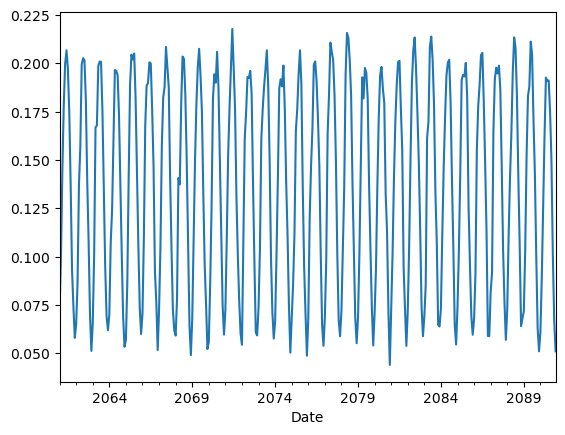

In [24]:
# Quick plot
df_selected.plot()
plt.show()
plt.close()

From the plot above we can have a quick look at the time series, however if we wanted to save this figure for later use, we might want to improve the visualization by adding a few details, such a title, a y-label to indicate the variable and units, a grid for better readibility, a line to indicate the zero line.

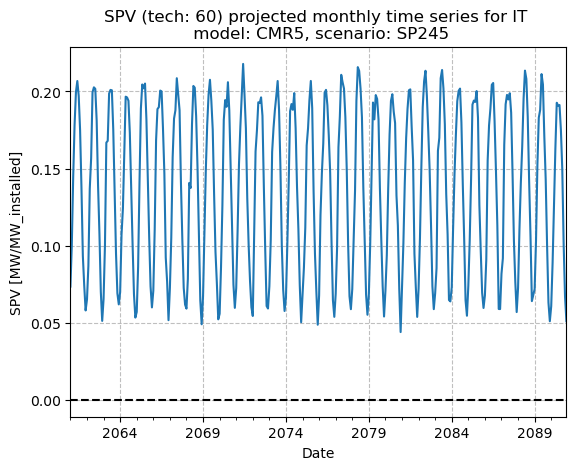

In [45]:
# refined plot
df_selected.plot()
plt.ylabel(f"{var_code} [{units}]")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.axhline(y=0.0, color="black", linestyle="dashed", linewidth=1.5)
plt.title(
    f"{var_code} (tech: {technology_str}) projected monthly time series for {country} \n"
    f" model: {model}, scenario: {scenario}"
)
plt.savefig(
    os.path.join(
        results_dir, f"P_{var_code}_{technology_str}_{country}_{model}_{scenario}_monthly_ts.png"
    )
)  # saving the plot
plt.show()
plt.close()

In case we wanted to plot more than one line together, we could do so by adding other DataFrame columns. Let's plot for example both the historical series and the previous projection as yearly averages.
And let's also try and quickly plot the whole DataFrame.

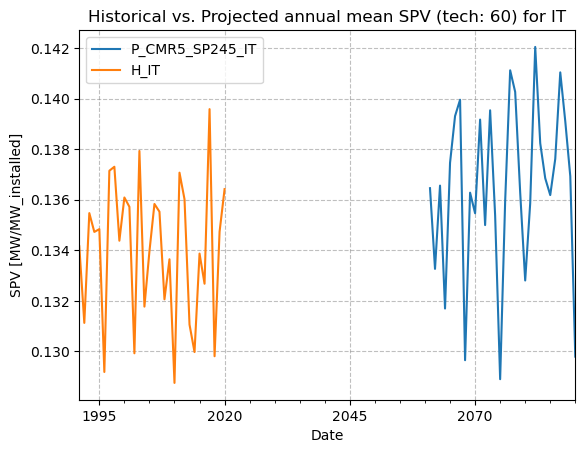

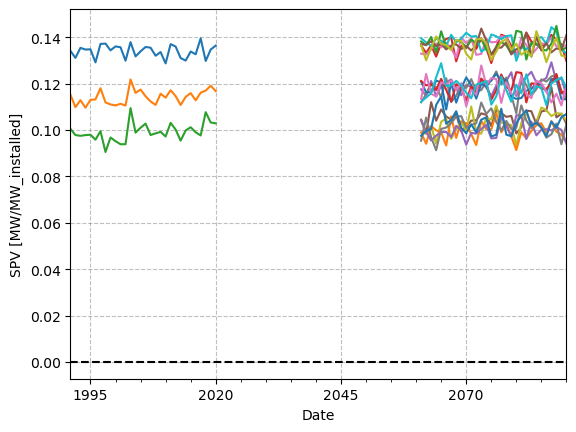

In [46]:
# Plotting 2 columns (hist + proj)
df[[selected_col, f"H_{country}"]].resample("YS").mean().plot()
plt.ylabel(f"{var_code} [{units}]")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.title(f"Historical vs. Projected annual mean {var_code}"
          f" (tech: {technology_str}) for {country}")
plt.show()
plt.close()

# Plotting whole df
df.resample("YS").mean().plot(legend=False)
plt.ylabel(f"{var_code} [{units}]")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.axhline(y=0.0, color="black", linestyle="dashed", linewidth=1.5)
plt.show()
plt.close()

To go deeper into the analysis of historical and projected data, please have a look at [Notebook *climate-change-impacts.ipynb*](./climate-change-impacts.ipynb).

### Plot values on a map

We now want to visualize on a map some value for the different countries to have an idea of the spatial distribution of SPV. To do so, we can start by choosing one dataset (e.g. the projection data for model CMR5 and scenario SSP245), and calculating a mean of its values over time for each country. Knowing the dates (time coordinate) information are contained in the index, this can be achieved with one simple line.


First we need to select a dataset (e.g. a projection dataset, with its model and scenario) and compute an average over time of its SPV values.

In [28]:
# Selecting columns for CMR5 SSP245
model = "CMR5"
scenario = "SP245"
df_p = df.filter(like=f"P_{model}_{scenario}", axis="columns")

# Computing average over time (along index, which contains the dates)
df_mean = df_p.mean(axis=0)

# Converting to DataFrame with variable code as column name
df_mean = pd.DataFrame(df_mean, columns=(var_code,))
print(df_mean)

                      SPV
P_CMR5_SP245_IT  0.136471
P_CMR5_SP245_FR  0.119866
P_CMR5_SP245_DE  0.105550


At this point, we need to load a shape file of the countries of interest: a shapefile is a common geospatial file format used to store vector geographic data, such as points, lines, or polygons (e.g., cities, rivers, or, as in this case, country borders). At the path ```nut0_fpath``` we provide a shape file with the geometries of the countries of interest for the C3S PECD (Pan European Climate Database) domain, including Italy, France, and Germany.

In [29]:
# Loading and plotting shapefile of countries
shp00 = gp.read_file(nut0_fpath)
print(shp00)

   PECD_CODE                                           geometry
0         FR  MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...
1         HR  MULTIPOLYGON (((16.59681 46.47590, 16.85476 46...
2         HU  POLYGON ((22.12108 48.37831, 22.15531 48.40340...
3         AL  POLYGON ((19.83100 42.46645, 20.06740 42.55258...
4         AT  POLYGON ((15.75363 48.85218, 16.29009 48.73395...
5         BE  POLYGON ((4.75993 51.50246, 4.86400 51.43362, ...
6         BG  POLYGON ((22.99717 43.80787, 23.40948 43.84985...
7         CH  POLYGON ((8.67046 47.68486, 8.79571 47.67560, ...
8         CY  POLYGON ((32.27382 35.06649, 32.28884 35.10503...
9         CZ  POLYGON ((14.61880 50.85780, 14.76738 50.81985...
10        DE  MULTIPOLYGON (((9.11310 54.87360, 9.29405 54.8...
11        DK  MULTIPOLYGON (((15.15353 55.07771, 15.08181 54...
12        EE  MULTIPOLYGON (((25.83016 59.56406, 25.89485 59...
13        EL  MULTIPOLYGON (((27.88675 35.95839, 27.74545 35...
14        IE  MULTIPOLYGON (((-7.25607 5

As we see, the file contains a column with the countries' ISO_CODES (column name is 'PECD_CODE'), and a column with their geometries (borders). All we need to do now is to merge the two sets following the ISO CODES. We will then make sure the ISO CODES are contained in both DataFrames' index and then we will merge.

In [30]:
# setting ISO CODES as the shape file index
shp00 = shp00.set_index("PECD_CODE")
print(shp00.head())

# renaming df_p index leaving just ISO_CODES (to match the shape file index)
df_mean.index = df_mean.index.str[-2:]  # mind: ISO_CODE closes the column name
print(df_mean)

# merging the two keeping only right df's index iso codes (ones of interest)
shp_data = shp00.merge(df_mean, left_index=True, right_index=True, how="right")
print(shp_data)

                                                    geometry
PECD_CODE                                                   
FR         MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...
HR         MULTIPOLYGON (((16.59681 46.47590, 16.85476 46...
HU         POLYGON ((22.12108 48.37831, 22.15531 48.40340...
AL         POLYGON ((19.83100 42.46645, 20.06740 42.55258...
AT         POLYGON ((15.75363 48.85218, 16.29009 48.73395...
         SPV
IT  0.136471
FR  0.119866
DE  0.105550
                                             geometry       SPV
IT  MULTIPOLYGON (((12.47792 46.67984, 12.69064 46...  0.136471
FR  MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...  0.119866
DE  MULTIPOLYGON (((9.11310 54.87360, 9.29405 54.8...  0.105550


We now have the GeoDataFrame (a table with geospatial information, along with variable values) needed for the map. We can then define a function that plots it and saves the figure to a specified output path. The function will take as input the following arguments:

*   `shp_data`: A `geopandas.GeoDataFrame` which should contain the geographical geometries of the regions (or countries) under a column named 'geometry', and the data values to be plotted for each region under a column named with the `short_var_name`. The index of this GeoDataFrame should correspond to the region codes.
*   `short_var_name`: A string representing the abbreviated name of the variable being plotted (e.g., 'SPV').
*   `var_units`: A string representing the units of the variable being plotted (e.g., 'kW/kW_installed').
*   `num_levels`: An integer specifying the number of discrete color levels to use in the colorbar.
*   `title`: A string for the title of the plot.
*   `outpath`: A string specifying the file path where the generated plot image will be saved.
*   `vmin`: An integer representing the minimum value for the color mapping.
*   `vmax`: An integer representing the maximum value for the color mapping.
*   `cmap`: A string specifying the colormap to use for the plot (defaults to 'viridis').


Inside the function:

*   A new figure and axes are created using `matplotlib.pyplot.figure` and `matplotlib.pyplot.axes`. The `projection=ccrs.PlateCarree()` argument indicates that the map will use the Plate Carree projection, a common geographical projection (more about PlateCarree() [here](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html)).
*   `ticks` for a discrete colorbar are calculated based on the `vmin`, `vmax`, and `num_levels` provided.
*   A discrete colormap and a normalization object (`norm`) are created using `matplotlib.colors.ListedColormap` and `matplotlib.colors.BoundaryNorm` to map the data values to the specified color levels.
*   The geographical data from the `shp_data` GeoDataFrame is plotted onto the axes using the `.plot()` method. The `column` argument specifies which column in `shp_data` contains the values to be colored on the map. `transform=ccrs.PlateCarree()` ensures the data is plotted correctly on the chosen projection. `legend=False` is used because a custom discrete colorbar is being created manually.
*   A manual discrete colorbar is added to the plot using `matplotlib.pyplot.colorbar`. This provides a visual scale for the data values displayed on the map.
*   Another plot is added for the region (or country) borders (`shp_data['geometry'].plot`). The `facecolor='none'` and `edgecolor='black' `settings make the regions (or countries) appear as outlines.
*   The `title` is set for the plot.
*   The plot is saved to the file path specified by `outpath` using `matplotlib.pyplot.savefig`.
*   The plot is displayed using `matplotlib.pyplot.show()`.
*   Finally, `matplotlib.pyplot.close()` is called to close the figure and free up memory.

In [39]:
def plot_regional_map(
    shp_data: gp.GeoDataFrame,
    short_var_name: str,
    var_units: str,
    num_levels: int,
    title: str,
    outpath: str,
    vmin: int,
    vmax: int,
    cmap: str = "viridis",
):
    # Plotting parameters
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ticks for discrete colorbar
    ticks = np.linspace(vmin, vmax, num_levels + 1)
    # cmap for discrete colorbar
    cmap = plt.get_cmap(cmap)
    cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, num_levels)))
    norm = mcolors.BoundaryNorm(ticks, ncolors=num_levels)
    # parameters for colorbar
    rc2 = {"axes.edgecolor": "white", "xtick.color": "white", "xtick.labelcolor": "black"}

    # Plotting data
    shp_data.plot(
        ax=ax,
        column=short_var_name,
        transform=ccrs.PlateCarree(),
        legend=False,  # setting manually discrete colormap
        cmap=cmap,
        norm=norm,  # needed for discrete values
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=0.2,
    )

    # manually setting discrete colorbar
    cbar_label = f"{short_var_name} [{var_units}]"
    with plt.rc_context(rc2):
        cbar = plt.colorbar(
            ax.collections[0],
            ax=ax,
            orientation="horizontal",
            aspect=30,
            extend="neither",
            pad=0.04,
            shrink=0.55,
            ticks=ticks,
            spacing="uniform",
            label=cbar_label,
            drawedges=True,
        )
        cbar.dividers.set_linewidth(4)

    # Plotting map of countries
    shp_data["geometry"].plot(ax=ax, linewidth=0.5, edgecolor="black", facecolor="none")
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

Once the function is defined, we can simply call it defining the needed arguments:

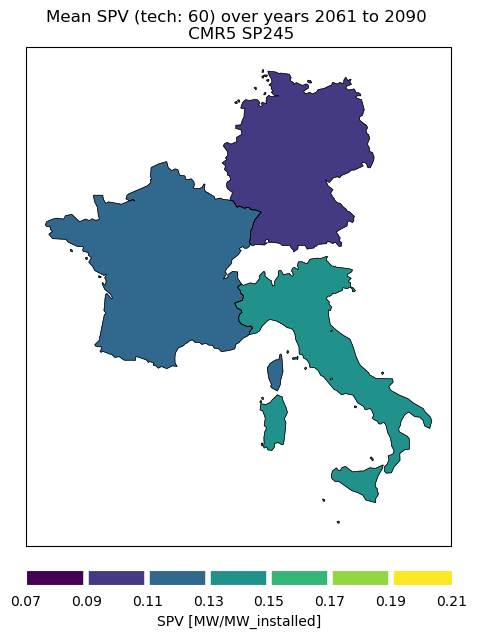

In [40]:
# Defining output path for figure
outpath = os.path.join(
    results_dir, f"mean_proj_{var_code}_{technology_str}_{start_year_p}_{end_year_p}.png"
)
title = (f"Mean {var_code} (tech: {technology_str}) over years {start_year_p} to {end_year_p}"
         f" \n {model} {scenario}")
# Calling function
plot_regional_map(
    shp_data=shp_data,
    short_var_name=var_code,
    var_units=units,
    num_levels=7,
    title=title,
    outpath=outpath,
    vmin=0.07,
    vmax=0.21,
    cmap="viridis",
)

## Take home messages 📌

*   Climate data stored in CSV files can be easily read, explored, and summarized using pandas.
*   Mean values over time can be computed and compared across countries using simple operations.
*   Time series for selected countries can be plotted using matplotlib for visual comparison.
*   Resampling to lower temporal resolution can be useful to better visualize and compare the data.
*   Regional mean values can be visualized on a map by joining tabular data with shapefiles.
*   Geopandas and Cartopy enable clean and customizable geographic visualizations.